## Validate Gain Flaggin

In [2]:
import matplotlib.pyplot as plt
import os
%matplotlib inline

### Data generation 

We had simulated data using Oskar. The simulation scripts are present in `scripts/ska_low_sim`.

We have simulated measurement set with phase and amplitude corruption.

#### Simulation Configuration for gain flagging

`sim.yaml`

```yaml
scenario: "low40s-model"          # Scenario name (used for output folder prefix)

# ===============================
# Global simulation parameters
# ===============================

n_stations: 40                                         # Number of stations
tel_model: "./telescope-models/SKA-Low_AA2_40S_rigid-rotation_model.tm" # Telescope model directory

simulation_start_frequency_hz: 123.0e6                  # Start frequency (Hz)
simulation_end_frequency_hz: 153.0e6                    # End frequency (Hz)
correlated_channel_bandwidth_hz: 21.70138888888889e3    # Channel width (Hz)

observing_time_mins: 10                              # Observation duration (minutes)
sampling_time_sec: 3.3973862400000003                   # Dump/integration time (seconds)

fields:
  EoR2:
    Cal1:
      ra_deg: 197.914612
      dec_deg: -22.277973
      scan_id_start: 300
      transit_time: "2000-01-03 22:33:30.000"

# ==================================
# Options for generate_gaintable.py
# ==================================

generate_gaintable:
  output_gaintable: &gen_gaintable "./gain-tables/custom_gaintable.h5"

  outlier_config:
    enable: true
    amp_min: 2.0
    amp_max: 5.0
    n_stations_to_corrupt: 20
    n_channels_to_corrupt: 100

  station_offset: true              # Apply per-station amplitude/phase offsets
  time_variant: true                # Apply time-dependent effects

  rfi: false                        # Inject RFI band
  rfi_start_freq_hz: 154.25347222228538e6        # Hz
  rfi_end_freq_hz: 159.8090277778474e6           # Hz

  plot: true                        # Generate diagnostic plots
  plot_output_dir: "./gain-tables/generation_plots/"

# ===============================
# Options for run_sim.py
# ===============================

run_sim:
  oskar_sif: "./OSKAR-2.11.1-Python3.sif" # Path to OSKAR Singularity image

  # GLEAM sky model. Optional. Comment to disable.
  gleam_file: "./sky-models/GLEAM_EGC.fits" # GLEAM catalogue FITS file
  field_radius_deg: 10.0            # Radius of field of view (degrees)

  # Corruptions to be applied. All are optional. Comment to disable.
  # gaintable: *gen_gaintable           # Gaintable containing bandpass corruptions
  # cable_delay: "./cable_delays/cable_length_error_40s.txt" # Cable delay error file
  # tec_screen: "./tec/calibrator_iono_tec.fits" # Ionospheric TEC screen FITS

  # Imaging parameters using wsclean. Optional. Comment to disable.
  create_dirty_image: true          # Whether to run wsclean imaging
  image_size: 1024                  # Image size (pixels)
  pixel_size: "2arcsec"             # Pixel size (angular units)

  # Extra parameters to pass directly to utils/run_oskar.py
  run_oskar_extra_params: "--use-gpus --double-precision"
```

First generate the gaintable using the command,

```
python generate_gaintable.py bandpass_delay_sim.yaml
```

Run the simulation.
```
python run_sim.py delay_sim.yaml
```

### Helper functions


### Pipeline setup 

In [4]:
cache = "../../cache"
artifacts_prefix_path = "./flag_gain_validation_artefacts"
os.makedirs(artifacts_prefix_path, exist_ok=True)

### With gain outliers

Running the data with bandpass plus gain outliers

In [7]:
input_data = "/home/swethaa/Documents/skao/other-repo/inst-inputs/sim-gain-flag.ms/"
flag_gain_artefacts_path = artifacts_prefix_path + "/flag_gain"
os.makedirs(flag_gain_artefacts_path, exist_ok=True)

In [ ]:
## Running the pipeline
!time ska-sdp-instrumental-calibration run \
    --input $input_data \
    --stages "load_data,predict_vis,bandpass_calibration,flag_gain" \
    --set parameters.load_data.cache_directory $cache \
    --set parameters.predict_vis.beam_type "everybeam" \
    --set parameters.predict_vis.normalise_at_beam_centre true \
    --set parameters.predict_vis.gleamfile "/home/swethaa/Documents/skao/other-repo/ical-input/gleamegc.dat" \
    --set parameters.flag_gain.plot_config.curve_fit_plot true \
    --set parameters.flag_gain.plot_config.gain_flag_plot true \
    --dask-scheduler "tcp://192.168.0.108:8786" \
    --output $flag_gain_artefacts_path

### Comparison and Validation

In our simulated data, we have corrupted these antennas
0, 1, 5, 6, 7, 12, 13, 18, 19, 20, 21, 22, 25, 26, 28, 33, 34, 36, 37, 39


Note: The current behaviour of poly flag is super sensitive to lower RMS value (it will flag a lot when RMS is low [<2.0])

In [68]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
bandpass_gt = flag_gain_artefacts_path + "/ska_sdp_instrumental_calibration_2026-02-12T08:04:04/gaintables/bandpass.gaintable.h5parm"
gainflag_gt = flag_gain_artefacts_path + "/ska_sdp_instrumental_calibration_2026-02-12T08:04:04/gaintables/gain_flag.gaintable.h5parm"

In [ ]:
bandpass_h5 = h5py.File(bandpass_gt)
gainflag_h5 = h5py.File(gainflag_gt)

In [ ]:

bpp = bandpass_h5["sol000"]["amplitude000"]["val"]
fg = gainflag_h5["sol000"]["amplitude000"]["val"]

In [35]:

def plot_selected_antennas(
    gain,
    flagged_gain,
    antennas=None,
    start_channel=None,
    end_channel=None
):

    t = 0
    _, n_ant, n_freq, n_pol = gain.shape

    if antennas is None:
        antennas = list(range(min(10, n_ant)))

    if start_channel is None:
        start_channel = 0
    if end_channel is None or end_channel > n_freq:
        end_channel = n_freq

    channels = np.arange(start_channel, end_channel)

    for ant in antennas:

        fig, axes = plt.subplots(1, n_pol, figsize=(5*n_pol, 4), sharey=True)

        if n_pol == 1:
            axes = [axes]

        for pol in range(n_pol):

            g = gain[t, ant, start_channel:end_channel, pol]
            fg = flagged_gain[t, ant, start_channel:end_channel, pol]

            axes[pol].plot(channels, np.abs(g), label="Gain", linewidth=2)
            axes[pol].plot(channels, np.abs(fg), label="Flagged Gain", linestyle="--")

            axes[pol].set_title(f"Antenna {ant} | Pol {pol}")
            axes[pol].set_xlabel("Channel")
            axes[pol].grid(True)
            axes[pol].legend()

        axes[0].set_ylabel("Amplitude")

        fig.suptitle(
            f"Amplitude vs Flagged Amplitude",
            fontsize=14
        )

        plt.tight_layout()
        plt.show()


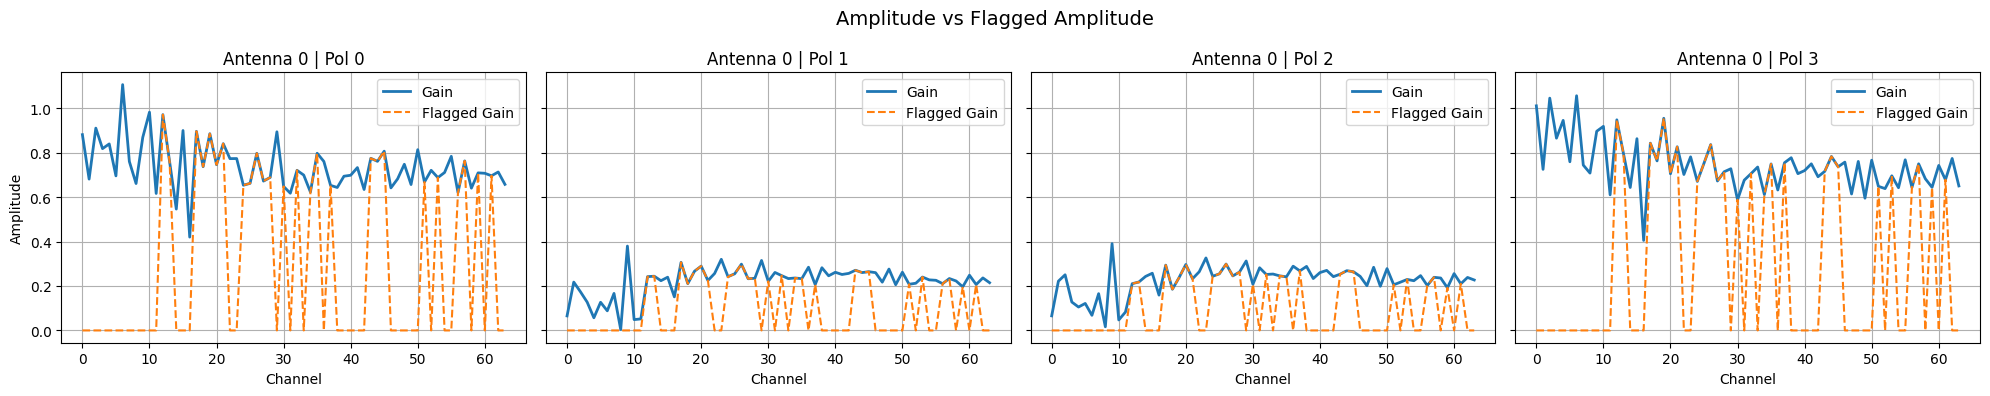

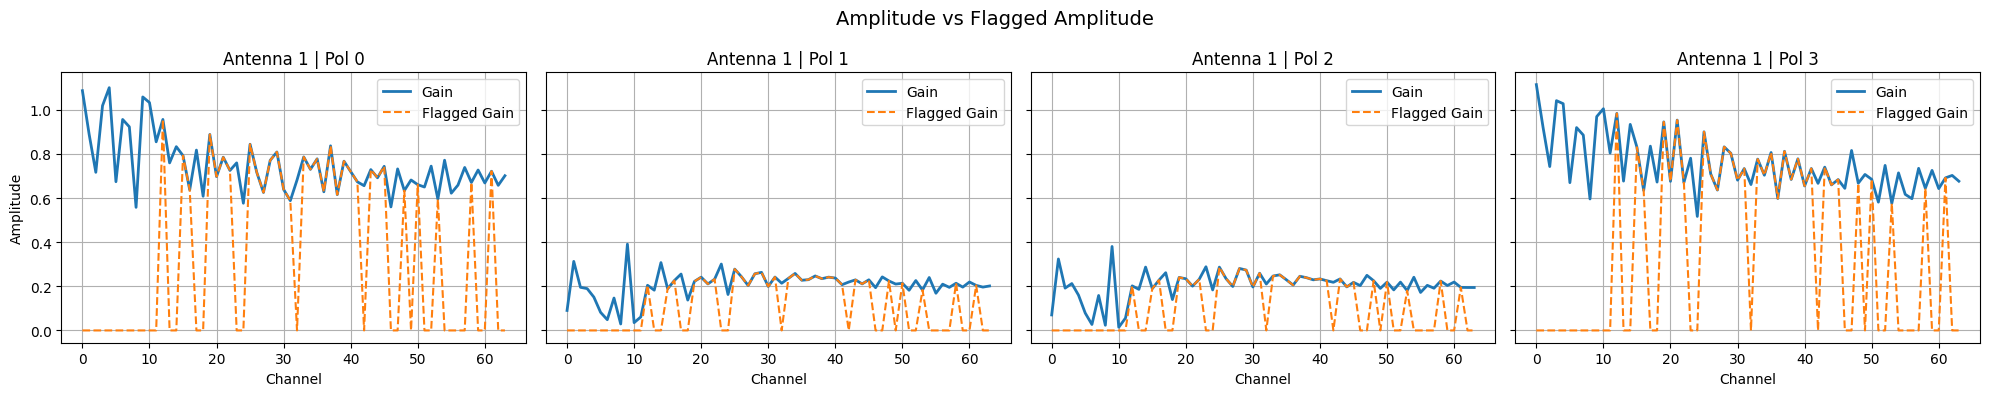

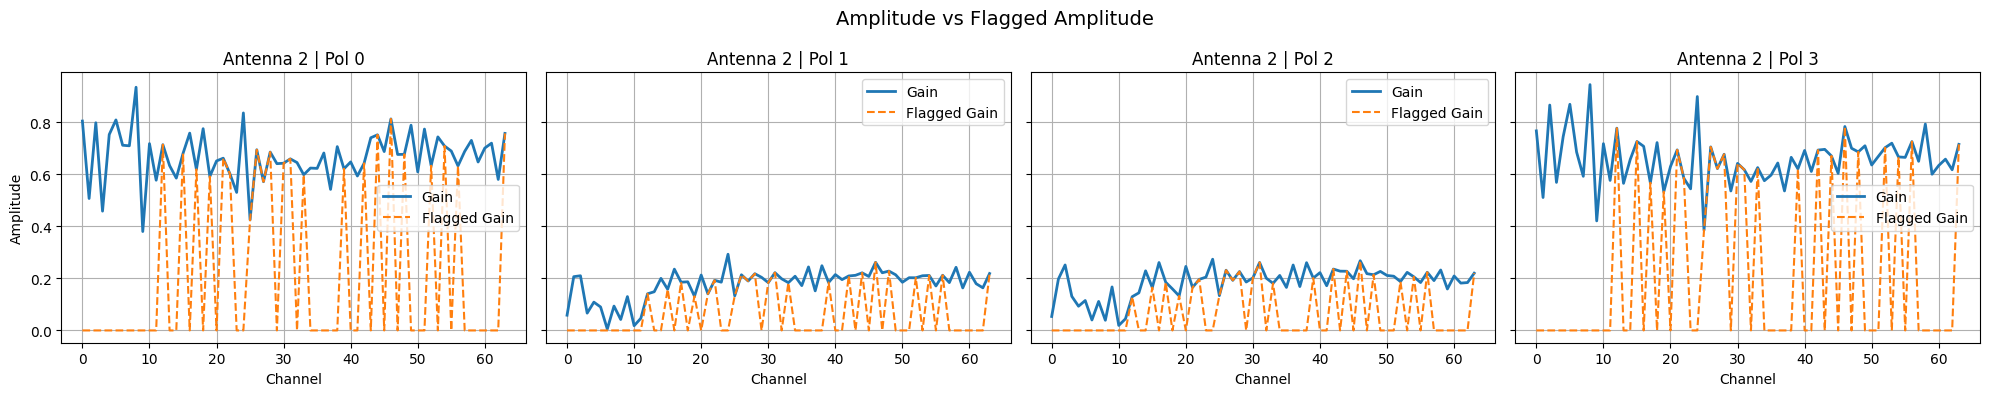

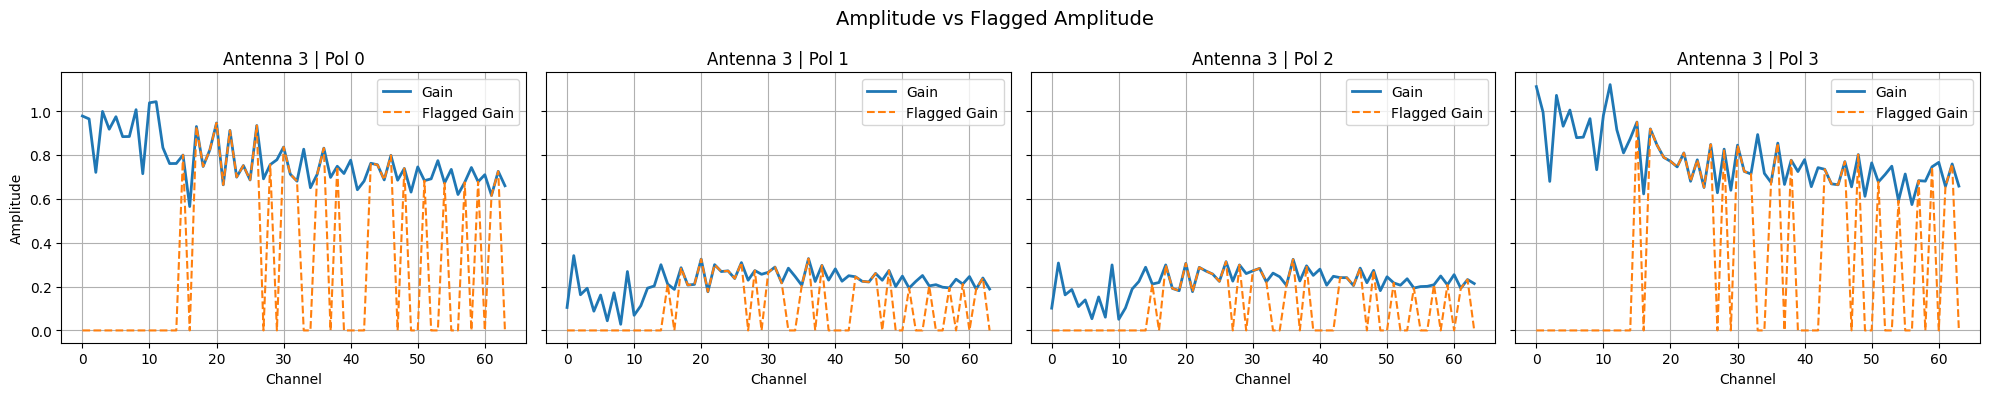

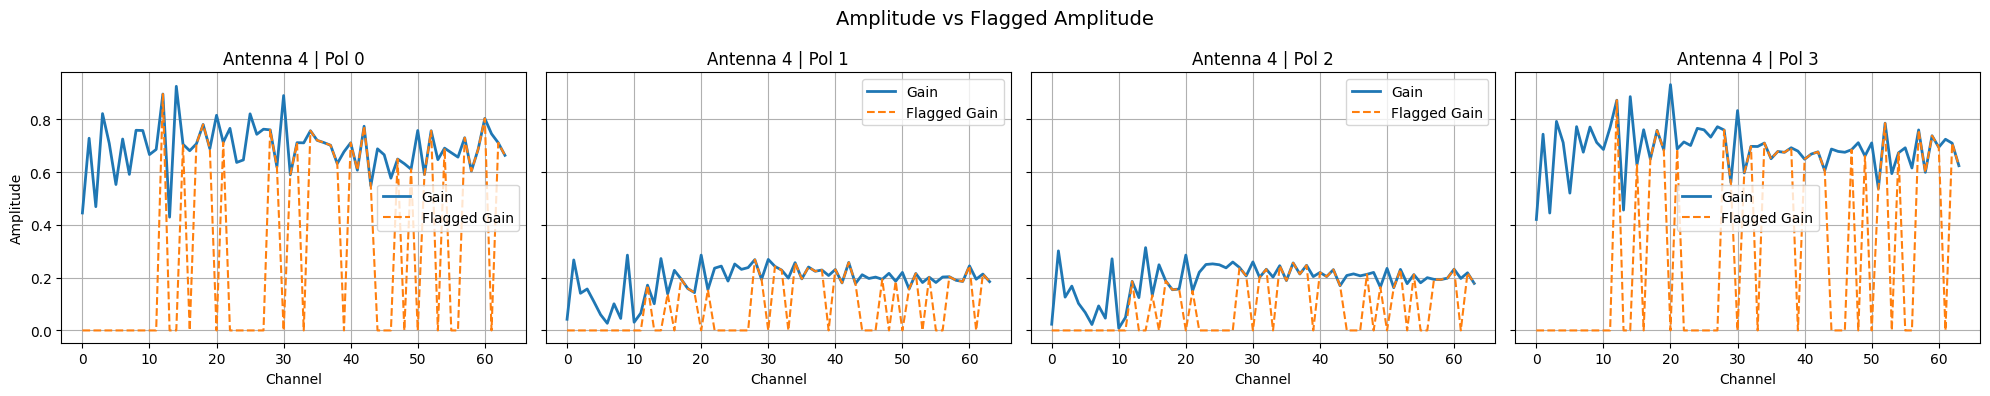

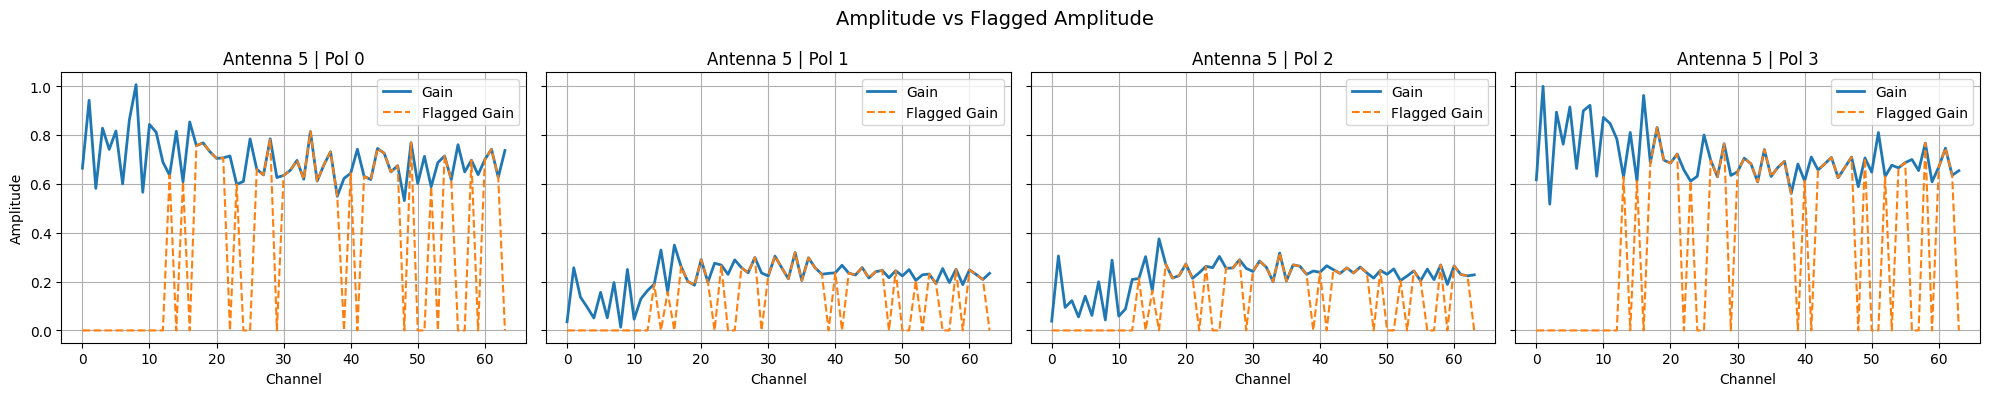

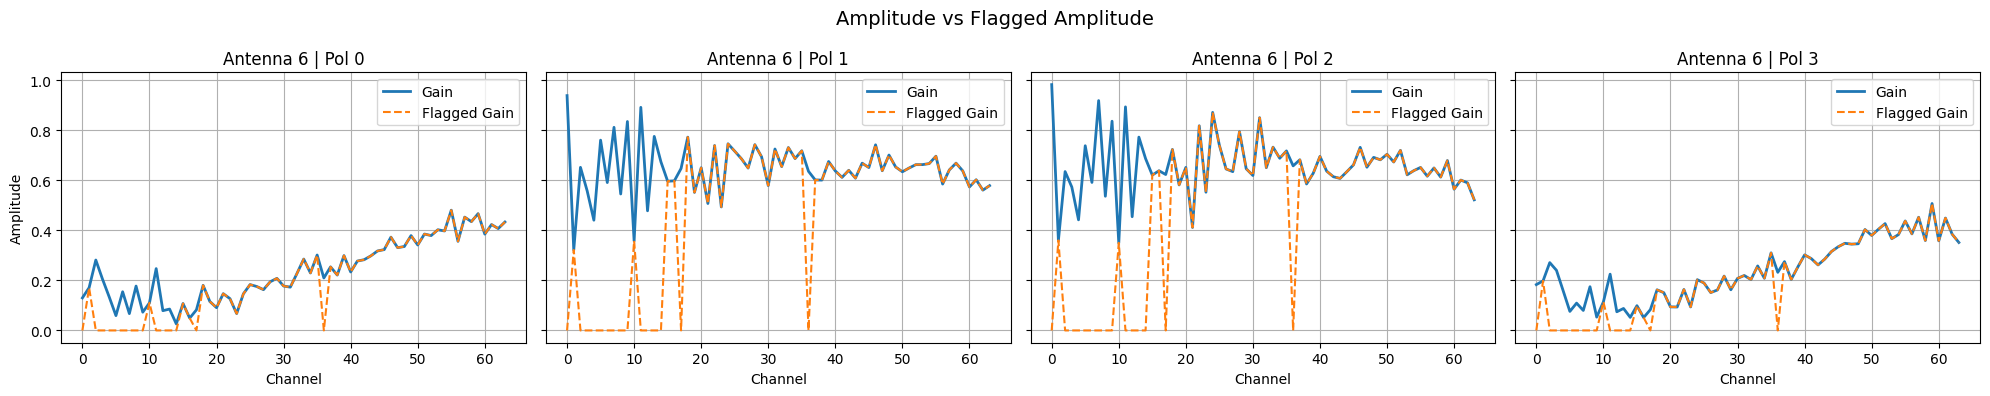

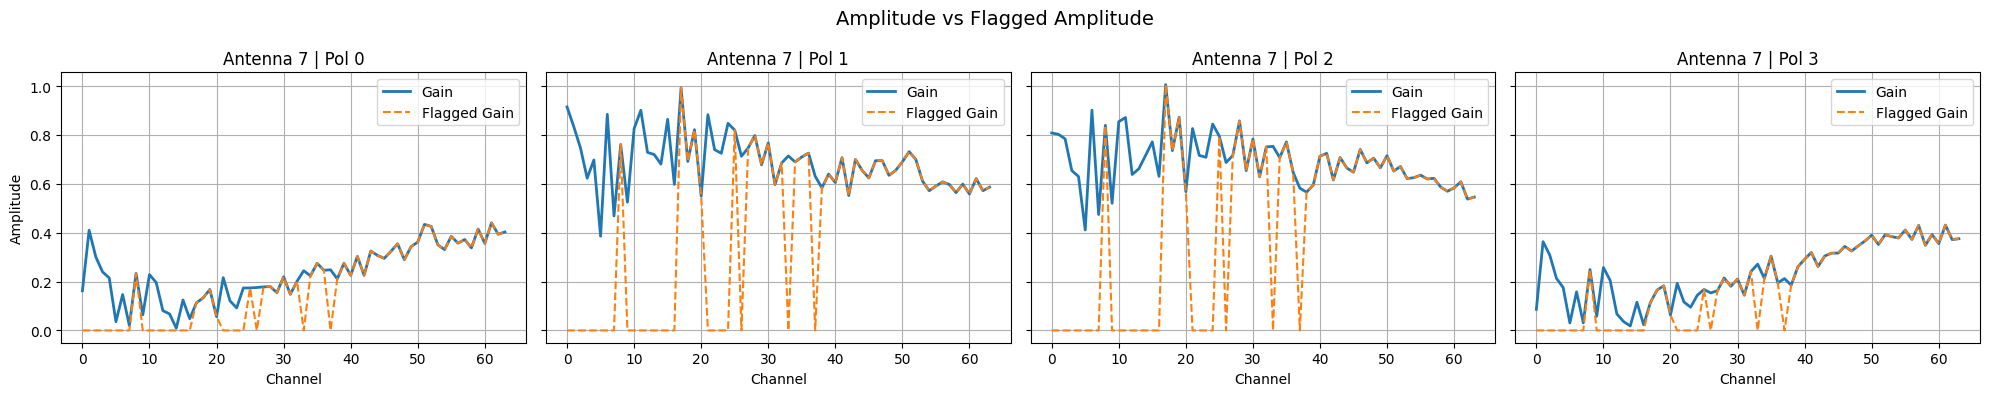

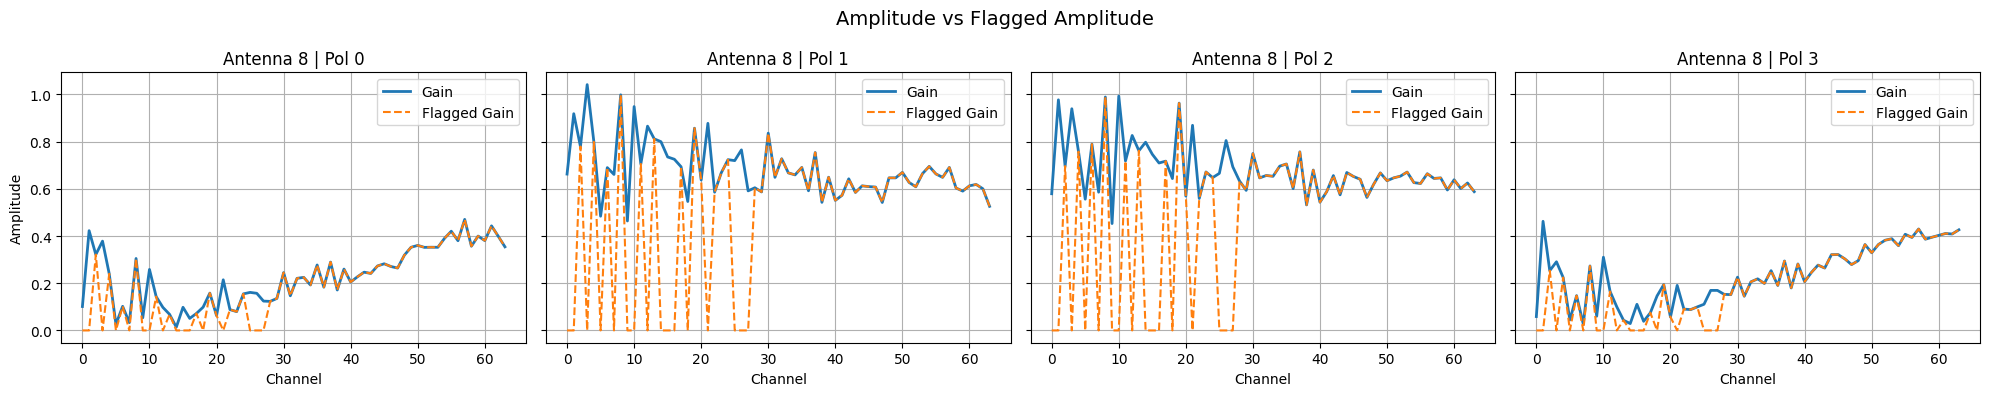

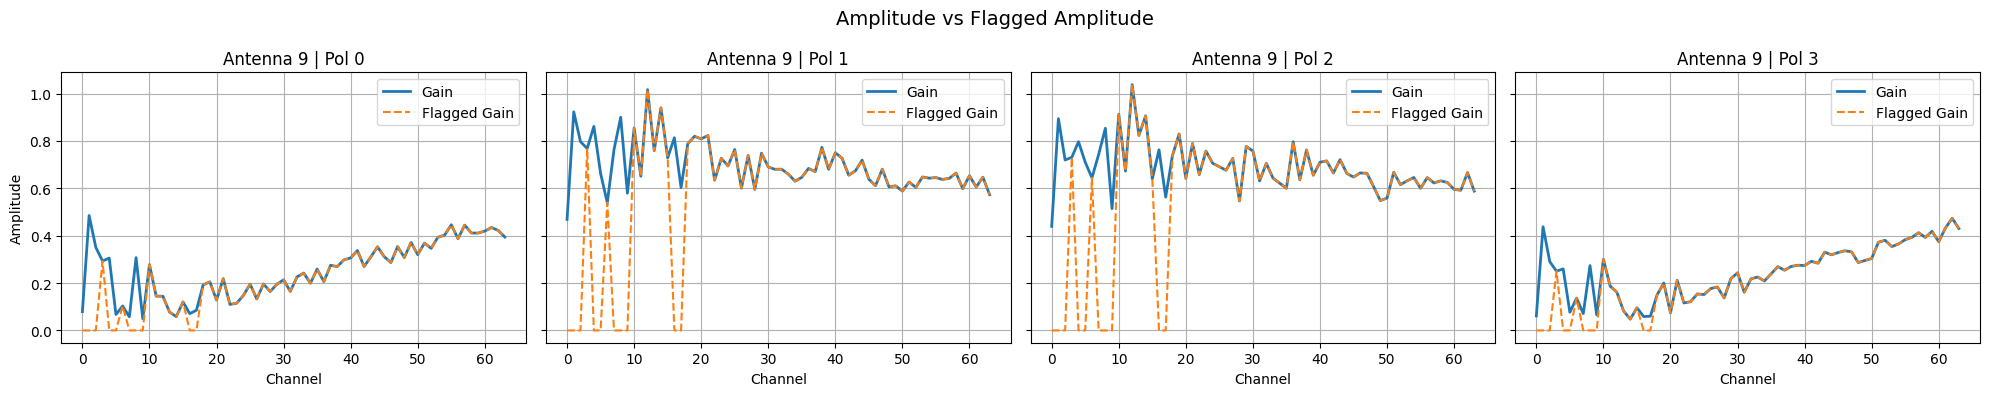

In [36]:
plot_selected_antennas(bpp, fg)

In [69]:

def plot_selected_antennas(
    gain,
    flagged_gain,
    antennas=None,
    start_channel=None,
    end_channel=None,
    plot_phase=True,
    show_unwrapped=True
):

    t = 0
    _, n_ant, n_freq, n_pol = gain.shape

    if antennas is None:
        antennas = list(range(min(10, n_ant)))

    if start_channel is None:
        start_channel = 0
    if end_channel is None or end_channel > n_freq:
        end_channel = n_freq

    channels = np.arange(start_channel, end_channel)

    for ant in antennas:

        fig, axes = plt.subplots(1, n_pol, figsize=(5*n_pol, 4), sharey=True)

        if n_pol == 1:
            axes = [axes]

        for pol in range(n_pol):

            g = gain[t, ant, start_channel:end_channel, pol]
            fg = flagged_gain[t, ant, start_channel:end_channel, pol]

            if plot_phase:
                phase = g
                flagged_phase = fg

                axes[pol].plot(channels, phase,
                               label="Wrapped Phase",
                               linewidth=2)

                axes[pol].plot(channels, flagged_phase,
                               label="Flagged Wrapped Phase",
                               linestyle="--")

                if show_unwrapped:
                    unwrapped = np.unwrap(phase)
                    axes[pol].plot(channels, unwrapped,
                                   label="Unwrapped Phase",
                                   linestyle="--",
                                   linewidth=2, color="red")

                axes[pol].set_ylabel("Phase")

            else:
                axes[pol].plot(channels, np.abs(g),
                               label="Gain", linewidth=2)

                axes[pol].plot(channels, np.abs(fg),
                               label="Flagged Gain", linestyle="--")

                axes[pol].set_ylabel("Amplitude")

            axes[pol].set_title(f"Antenna {ant} | Pol {pol}")
            axes[pol].set_xlabel("Channel")
            axes[pol].grid(True)
            axes[pol].legend()

        title_mode = "Phase" if plot_phase else "Amplitude"
        fig.suptitle(
            f"{title_mode} — Phase Vs Flagged Phase Vs Unwrapped Phase)",
            fontsize=14
        )
        
        plt.tight_layout()
        plt.show()



Phase values are unwrapped and given for comparison. It can be seen that not all values closer to pi to -pi are wrapped, meaning it is considered all the wrapped values as normal phases and not an ouliers

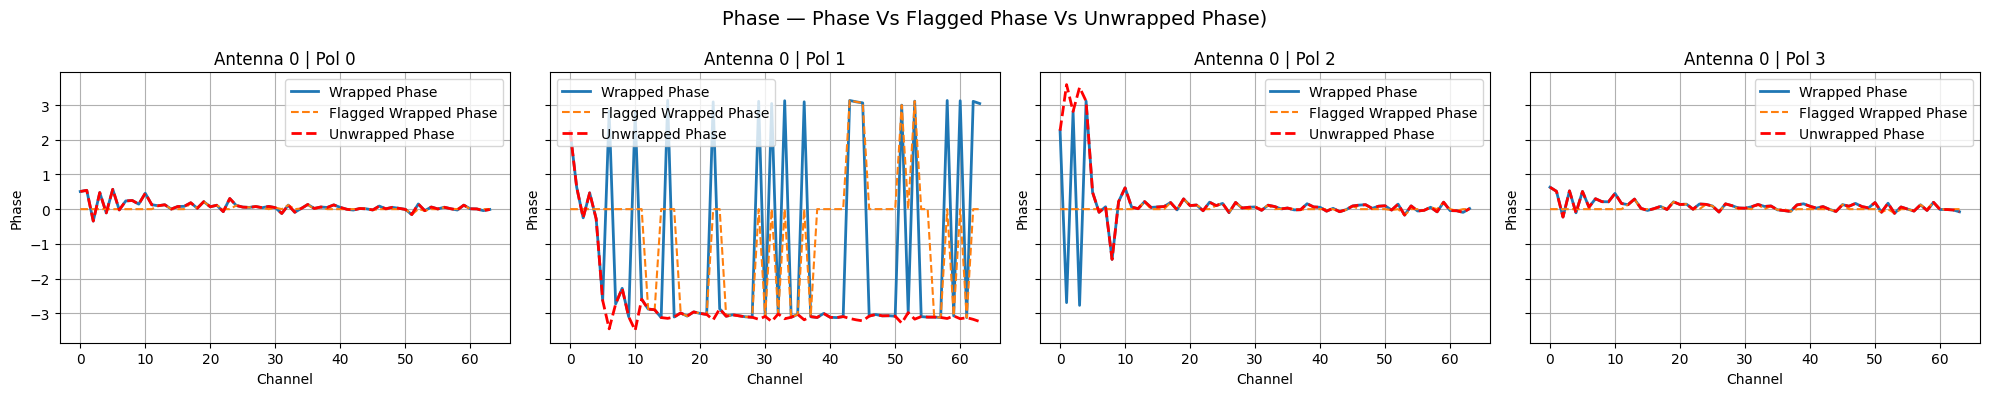

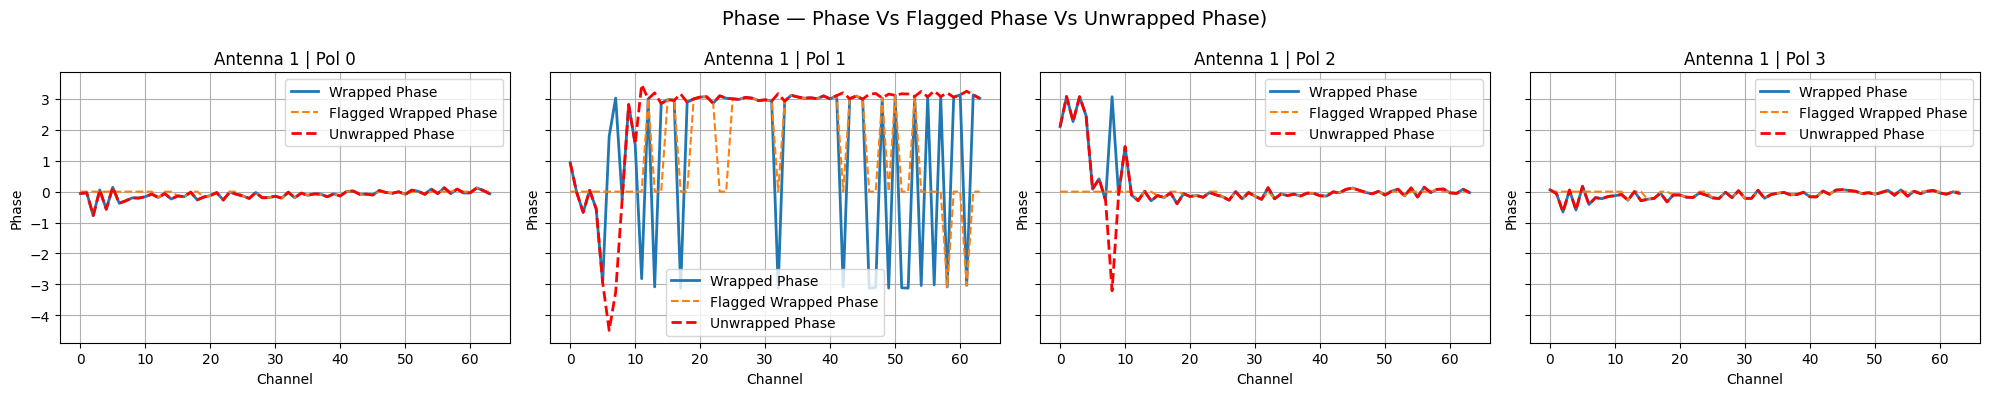

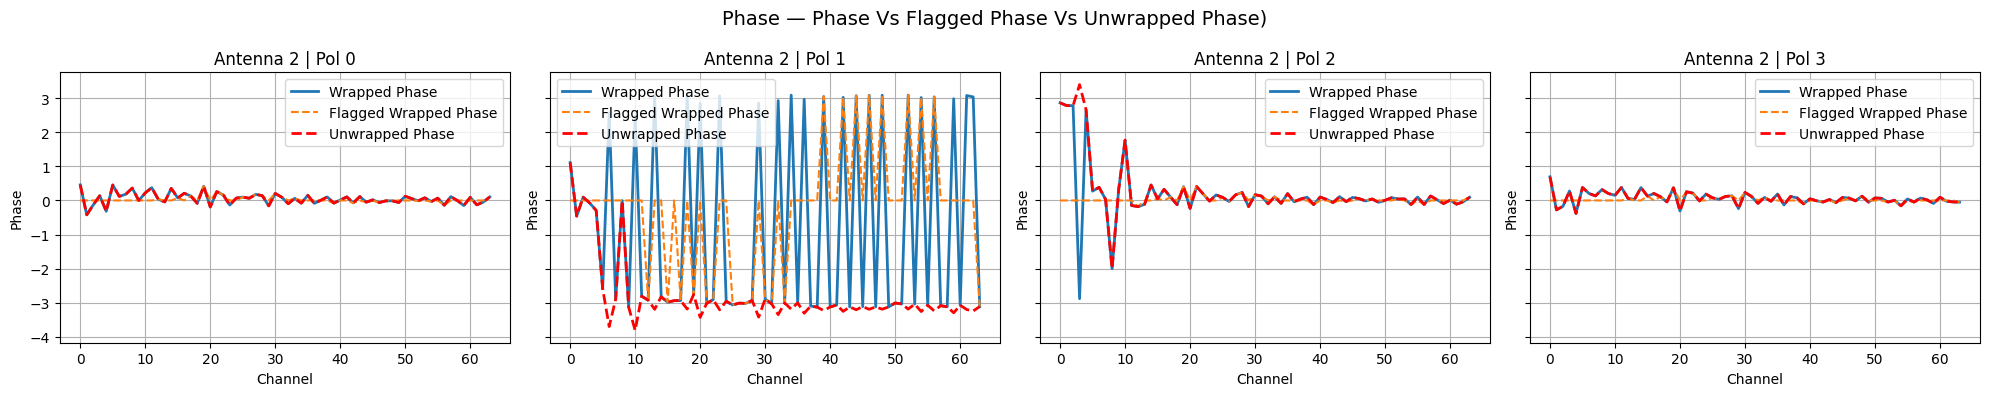

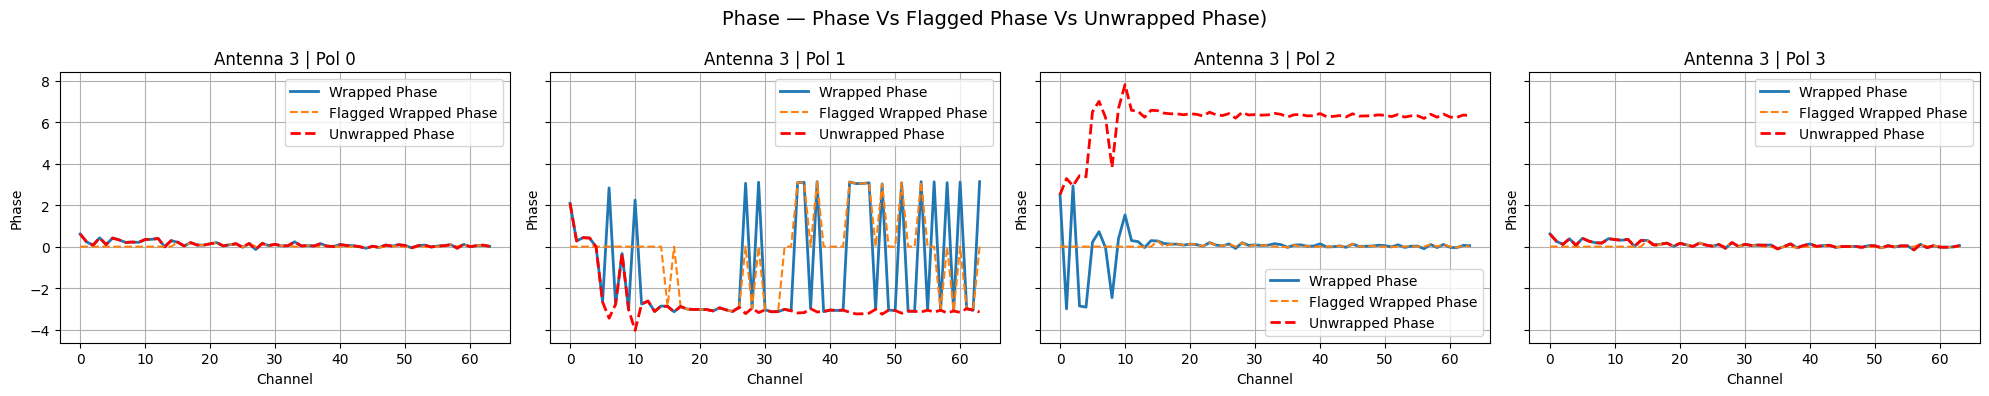

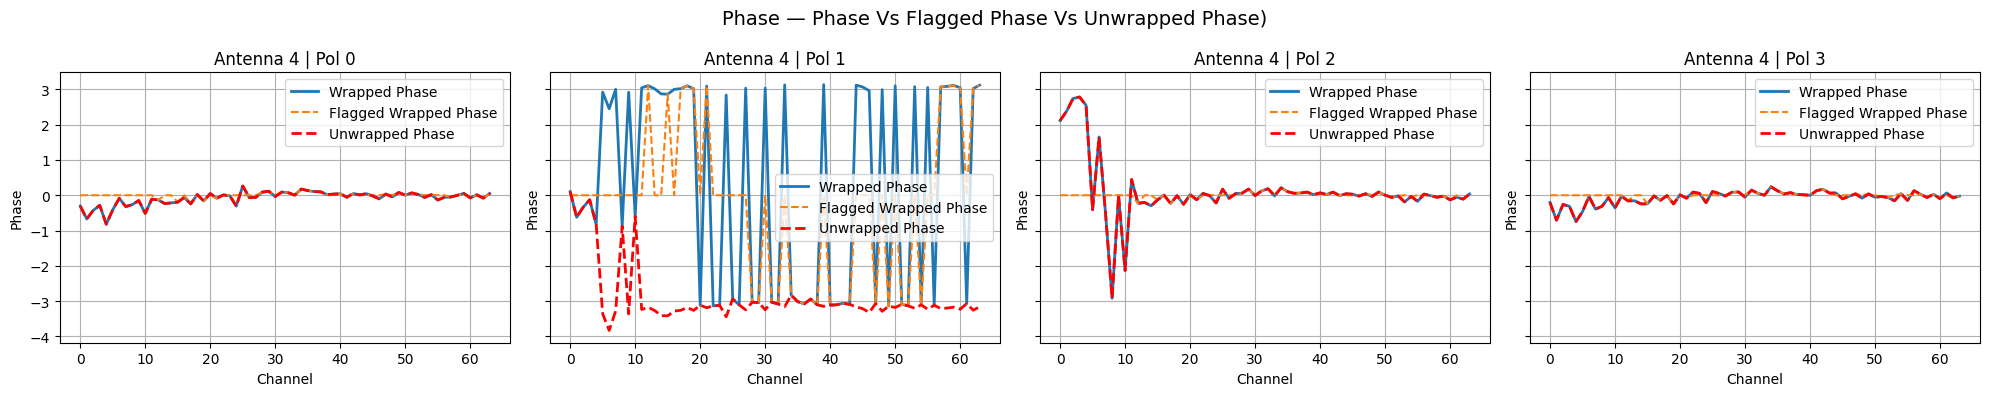

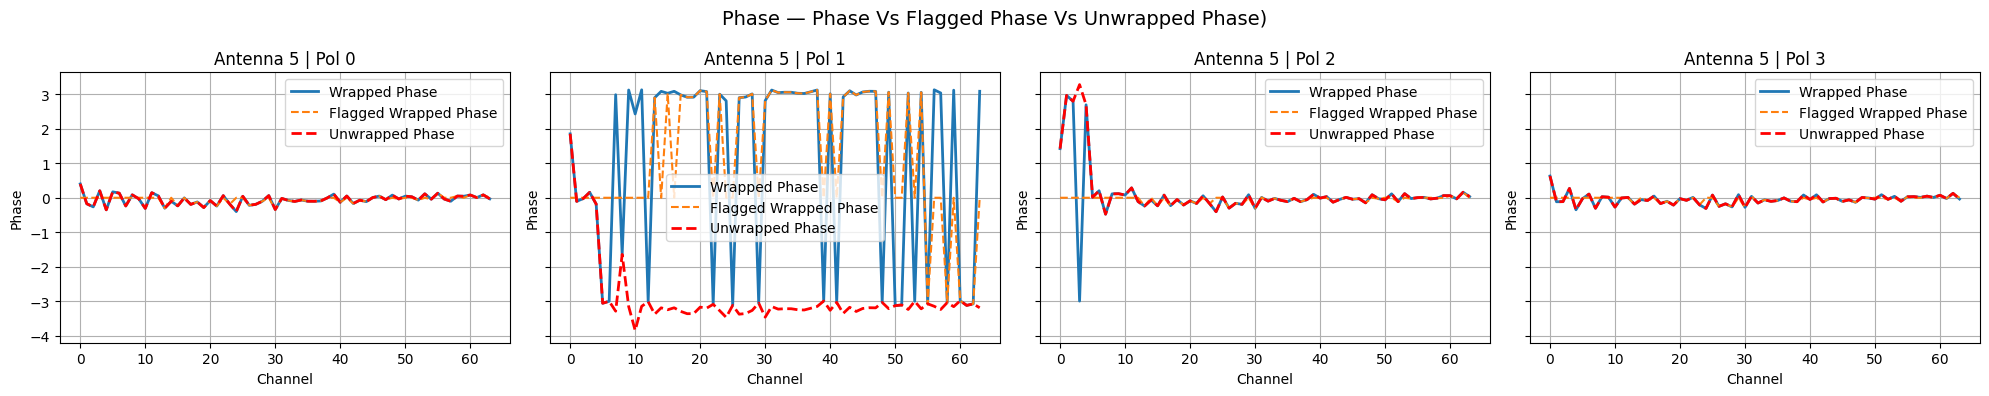

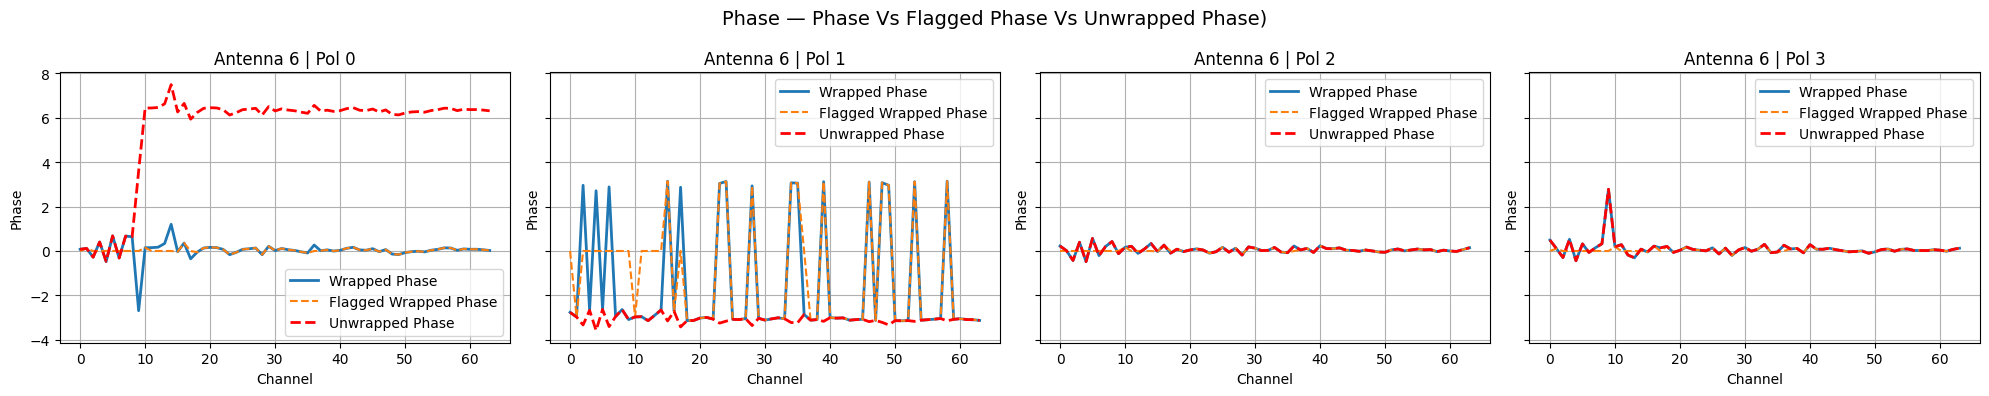

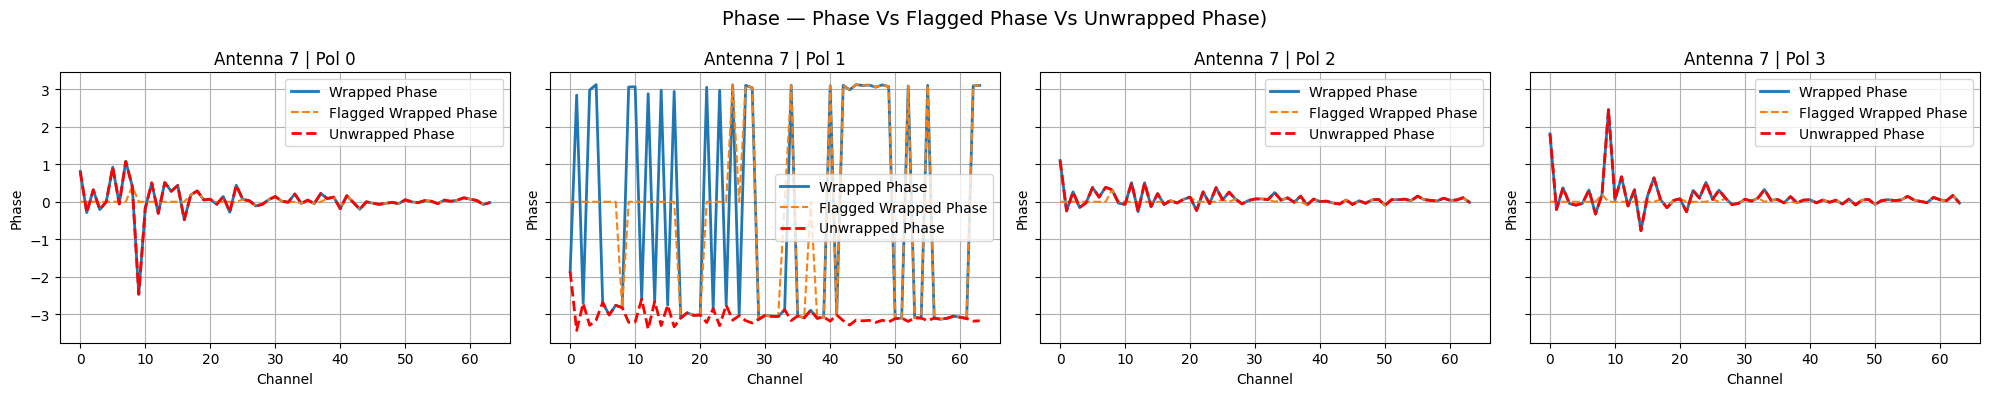

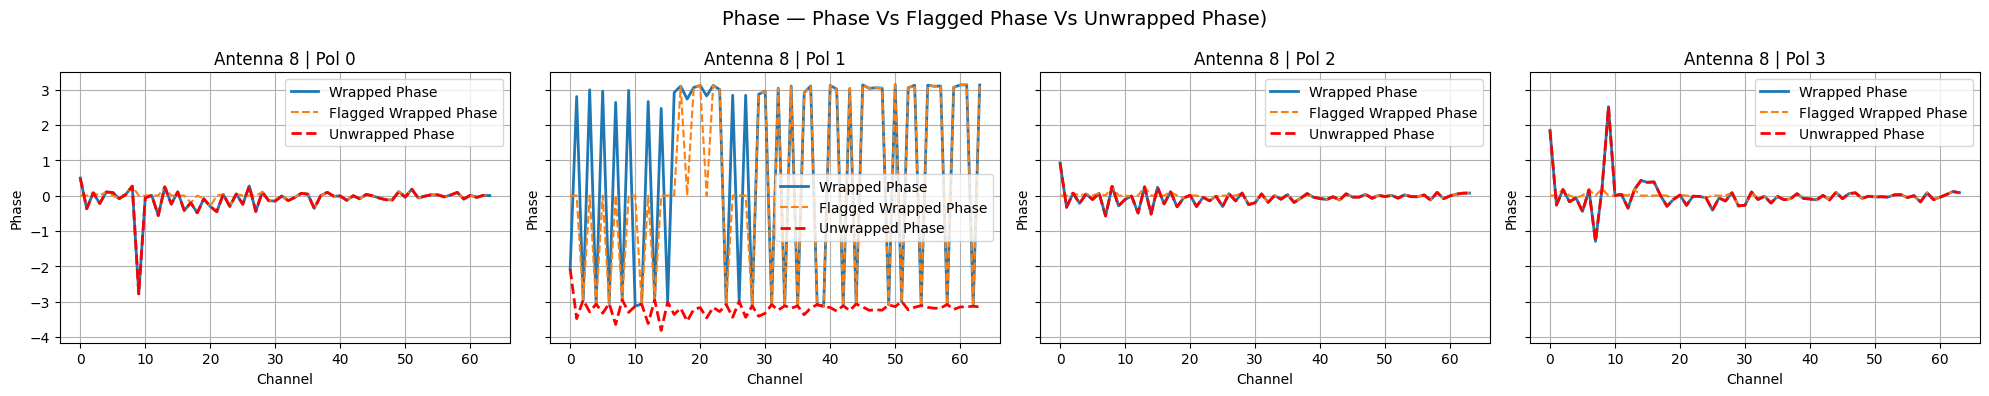

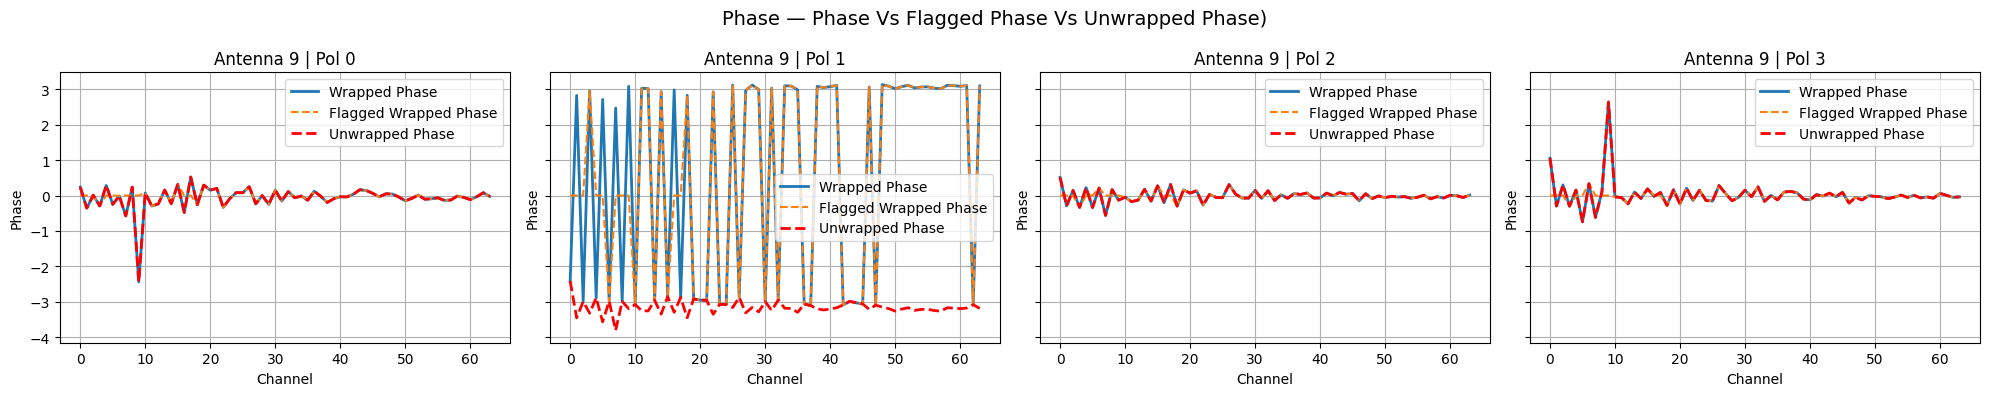

In [ ]:
bpp_ph = bandpass_h5["sol000"]["phase000"]["val"]
fg_ph = gainflag_h5["sol000"]["phase000"]["val"]


plot_selected_antennas(bpp_ph, fg_ph)